# Event Clustering Pipeline Visualization
This notebook demonstrates each stage of the pipeline and visualises intermediate graphs.

## 1. Load data

The data which is loaded here are the general data from the Event2012 for the events 'events2012_data_20k.csv'.

As well as data for the entities of the knowledge graph saved in the file 'entities.csv'.

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import normalized_mutual_info_score

nodes_df = pd.read_csv('entities.csv')
rels_df = pd.read_csv('events2012_data_20k.csv')
print(f'Entities: {len(nodes_df)}')
print(f'Relations: {len(rels_df)}')




Entities: 31483
Relations: 7736


In [ ]:
display(nodes_df.head(5))

,entity,type,chunk
0,Nobel prize,object,0
1,literature,object,0
2,Ateneo,organization,2
3,SMART,organization,3
4,CCTV,organization,4


## 2. Statistics by entities and relations

In [ ]:
print(nodes_df['type'].value_counts().head())
print(rels_df['predicate'].value_counts().head())

type
actor           13833
object           6907
organization     6207
toponym          3794
event             474
Name: count, dtype: int64
predicate
win          990
taser        202
arrest       194
use          183
terminate    171
Name: count, dtype: int64


## 3. Build entity knowledge graph

In [ ]:
def normalize_label(label):
    if pd.isna(label):
        return None
    return str(label).lower().lstrip('#')

def build_graph(nodes, relations):
    t_map = dict(zip(nodes['entity'].str.lower(), nodes['type']))
    c_map = dict(zip(nodes['entity'].str.lower(), nodes['chunk']))
    G = nx.DiGraph()
    for _, row in relations.iterrows():
        u_raw, v_raw = row['subject'], row['object']
        u, v = normalize_label(u_raw), normalize_label(v_raw)
        if not u or not v:
            continue
        for raw, norm in ((u_raw, u), (v_raw, v)):
            if not G.has_node(norm):
                G.add_node(norm, type=t_map.get(raw.lower()), chunk=c_map.get(raw.lower()), original_label=raw)
        G.add_edge(u, v, predicate=row.get('predicate'), time=row.get('time'), event_id=row.get('event_id'), weight=1.0)
    return G

G = build_graph(nodes_df, rels_df)
print('Graph nodes:', G.number_of_nodes())
print('Graph edges:', G.number_of_edges())

Graph nodes: 1842
Graph edges: 3092


## 4. Show graph


We can get the graph visualised using various layouts.


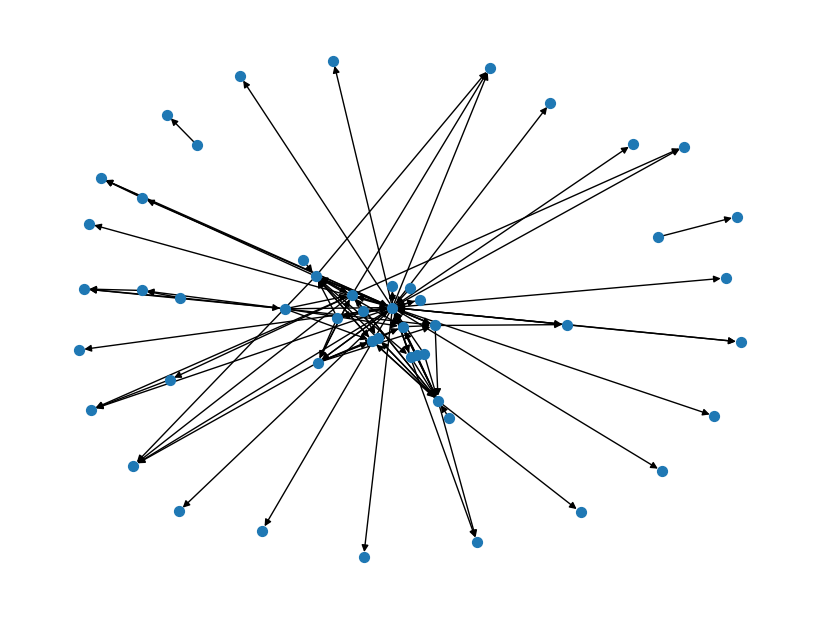

In [ ]:
sample_nodes = list(G.nodes())[:50]
H = G.subgraph(sample_nodes)
pos = nx.spring_layout(H, seed=42)
plt.figure(figsize=(8,6))
nx.draw(H, pos, node_size=50, with_labels=False)
plt.show()

## 5. Geo edges example

In [ ]:
import pandas as pd
from geopy.distance import geodesic
coords = pd.read_csv('toponyms_cache.csv').set_index('toponym').T.to_dict()

def add_geo_edges(G, coords, dist_thr=500):
    topo = [n for n,d in G.nodes(data=True) if d.get('type')=='toponym' and n in coords]
    for i,u in enumerate(topo):
        for v in topo[i+1:]:
            d = geodesic(coords[u], coords[v]).kilometers
            if d <= dist_thr:
                G.add_edge(u, v, edge_type='geo', distance_km=d)

add_geo_edges(G, coords)
geo_edges = [(u,v,d['distance_km']) for u,v,d in G.edges(data=True) if d.get('edge_type')=='geo']
print(geo_edges[:5])

ValueError: could not convert string to float: 'lat'

## 6. Split and merge demonstration

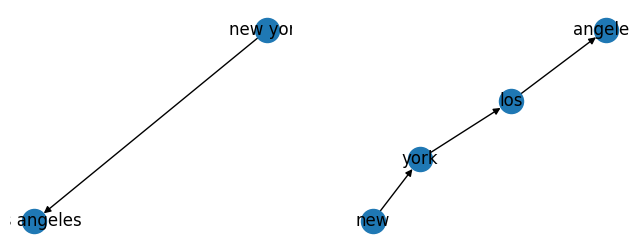

In [ ]:
def split_multiword_nodes(G):
    multi = [n for n in G if ' ' in n]
    for node in multi:
        attrs = G.nodes[node]
        toks = node.split()
        for t in toks:
            if not G.has_node(t):
                G.add_node(t, **attrs)
        for i in range(len(toks)-1):
            G.add_edge(toks[i], toks[i+1], label='related')
        for pred in list(G.predecessors(node)):
            G.add_edge(pred, toks[0], **G[pred][node])
        for succ in list(G.successors(node)):
            G.add_edge(toks[-1], succ, **G[node][succ])
        G.remove_node(node)
    return G

H = nx.DiGraph()
H.add_edge('new york', 'los angeles')
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
nx.draw(H, with_labels=True)
H2 = split_multiword_nodes(H.copy())
plt.subplot(1,2,2)
nx.draw(H2, with_labels=True)
plt.show()

## 7. Meta graph

In [ ]:
def build_meta_graph(G):
    H = nx.Graph()
    for n,d in G.nodes(data=True):
        c = d.get('chunk')
        if c is not None:
            H.add_node(c)
    for u,v,d in G.edges(data=True):
        cu = G.nodes[u].get('chunk')
        cv = G.nodes[v].get('chunk')
        if cu is None or cv is None or cu==cv:
            continue
        w = H[cu][cv]['weight']+1 if H.has_edge(cu,cv) else 1
        H.add_edge(cu, cv, weight=w)
    return H

meta = build_meta_graph(G)
print('Meta nodes:', meta.number_of_nodes())
print('Meta edges:', meta.number_of_edges())

Meta nodes: 1530
Meta edges: 2352


## 8. Community comparison

In [ ]:
import community as community_louvain
import igraph as ig, leidenalg

truth = rels_df.dropna(subset=['subject']).groupby('subject')['event_id'].agg(lambda x:x.mode()[0]).to_dict()
part_louvain = community_louvain.best_partition(meta)
labels_louvain = [part_louvain.get(n, -1) for n in meta]
ig_graph = ig.Graph.TupleList(meta.edges(), directed=False)
part_leiden = leidenalg.find_partition(ig_graph, leidenalg.RBConfigurationVertexPartition)
labels_leiden = part_leiden.membership
truth_labels = [truth.get(n, -1) for n in meta]
print('Louvain NMI', normalized_mutual_info_score(truth_labels, labels_louvain))
print('Leiden  NMI', normalized_mutual_info_score(truth_labels, labels_leiden))

ModuleNotFoundError: No module named 'igraph'